# Hypothesis 1: Shift in Tipping Culture

#### We attempt to answer the question: **After adjusting for confounding factors such as trip duration and surcharges, do customers in 2019 exhibit different tipping behavior than those in 2014?**

In [12]:
# Load data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('data/taxidata_clean.csv', parse_dates=['trip_start_timestamp'])
df['year'] = df['trip_start_timestamp'].dt.year
df['pct_tip'] = 100 * df['tips'] / df['fare'].replace(0, np.nan)
df['hour'] = df['trip_start_timestamp'].dt.hour
df['dow'] = df['trip_start_timestamp'].dt.dayofweek
df['speed_mph'] = 3600 * df['trip_miles'] / df['trip_seconds'].replace(0, np.nan)

# 1. Exploratory Data Analysis and additional Preprocessing

As seen below, the dataset seemingly did not include any cash tips, as most tips came from riders who paid using credit card.

In [13]:
c = df.assign(has_tip=df['tips']>0).groupby(['year','payment_type']).agg(
    n=('tips','count'), n_tips=('has_tip','sum')
).assign(pct_tipped=lambda x: 100*x['n_tips']/x['n'])
print('2014:'); display(c.loc[2014])
print('2019:'); display(c.loc[2019])

2014:


,n,n_tips,pct_tipped
payment_type,,,
Cash,128741,1,0.000777
Credit Card,68559,66209,96.572295
Dispute,150,0,0.000000
No Charge,1482,0,0.000000
Unknown,295,113,38.305085


2019:


,n,n_tips,pct_tipped
payment_type,,,
Cash,93658,46,0.049115
Credit Card,98682,94305,95.564541
Dispute,69,0,0.000000
Mobile,3479,3432,98.649037
No Charge,319,5,1.567398
Pcard,2,0,0.000000
Prcard,2085,158,7.577938
Prepaid,9,0,0.000000
Unknown,1314,39,2.968037


Text(0, 0.5, 'Density')

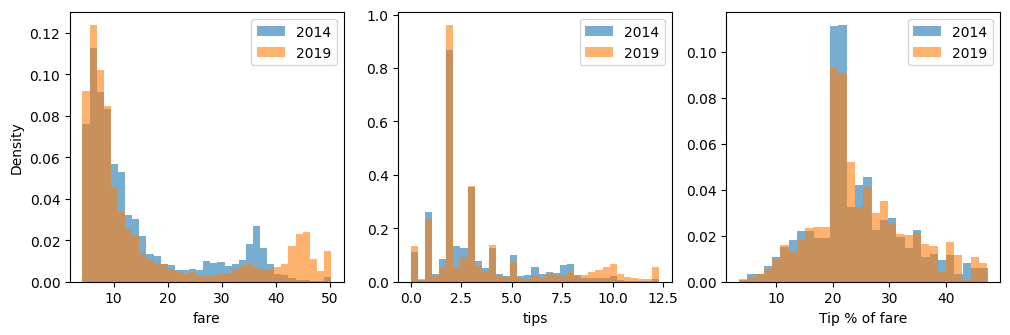

In [23]:
# CC users only: fare, tip, and tip % distributions, 2014 vs 2019
cc = df[(df['payment_type']=='Credit Card') & (df['fare']>0)].copy()
cc_pct = cc[cc['tips']>0][['year','pct_tip']].dropna()
q1, q3 = cc_pct['pct_tip'].quantile([0.25, 0.75])
cc_pct = cc_pct[(cc_pct['pct_tip']>=q1-1.5*(q3-q1)) & (cc_pct['pct_tip']<=q3+1.5*(q3-q1))]

fig, ax = plt.subplots(1, 3, figsize=(12, 3.5))
for col, ax_ in zip(['fare', 'tips'], ax[:2]):
    for y in [2014, 2019]:
        s = cc[cc['year']==y][col].clip(cc[col].quantile(0.01), cc[col].quantile(0.99))
        ax_.hist(s, bins=35, alpha=0.6, label=y, density=True)
    ax_.set_xlabel(col); ax_.legend()
for y in [2014, 2019]:
    ax[2].hist(cc_pct[cc_pct['year']==y]['pct_tip'], bins=30, alpha=0.6, label=y, density=True)
ax[2].set_xlabel('Tip % of fare'); ax[2].legend()
ax[0].set_ylabel('Density')

### Speed: 2014 vs 2019

Speed (mph) = trip_miles / (trip_seconds/3600). Trips with trip_seconds ≤ 0 excluded.

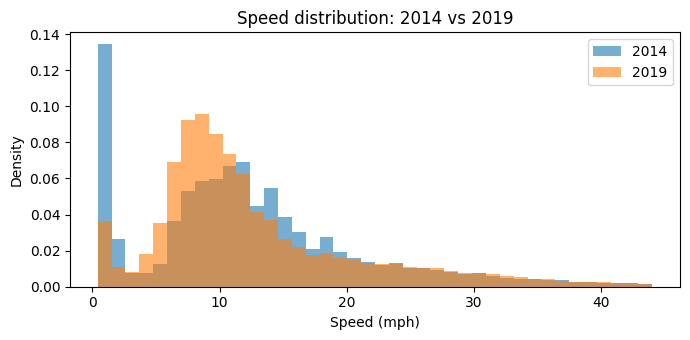

2014: mean=12.34 mph, median=11.20
2019: mean=12.73 mph, median=10.34


In [15]:
sp = df[df['trip_seconds']>0][['year','speed_mph']].dropna()
sp = sp[sp['speed_mph'].between(sp['speed_mph'].quantile(0.01), sp['speed_mph'].quantile(0.99))]

fig, ax = plt.subplots(figsize=(7, 3.5))
for y in [2014, 2019]:
    ax.hist(sp[sp['year']==y]['speed_mph'], bins=40, alpha=0.6, label=y, density=True)
ax.set_xlabel('Speed (mph)'); ax.set_ylabel('Density'); ax.legend()
ax.set_title('Speed distribution: 2014 vs 2019')
plt.tight_layout(); plt.show()

y14, y19 = sp[sp['year']==2014]['speed_mph'], sp[sp['year']==2019]['speed_mph']
print(f'2014: mean={y14.mean():.2f} mph, median={y14.median():.2f}')
print(f'2019: mean={y19.mean():.2f} mph, median={y19.median():.2f}')

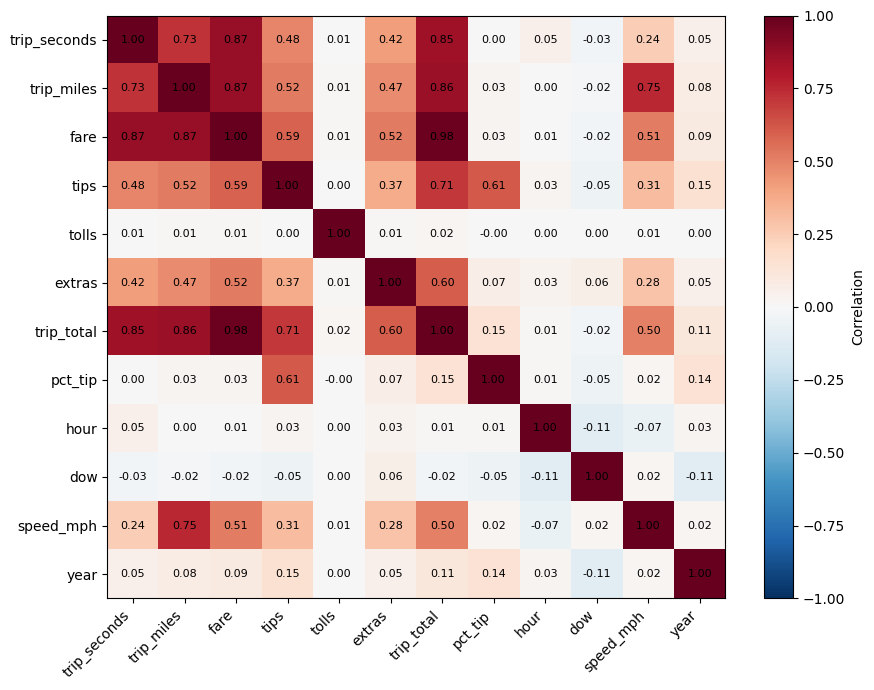

In [16]:
num_cols = ['trip_seconds', 'trip_miles', 'fare', 'tips', 'tolls', 'extras', 'trip_total', 'pct_tip', 'hour', 'dow', 'speed_mph', 'year']
corr = df[num_cols].corr()

fig, ax = plt.subplots(figsize=(9, 7))
im = ax.imshow(corr, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
ax.set_xticks(range(len(num_cols)))
ax.set_yticks(range(len(num_cols)))
ax.set_xticklabels(num_cols, rotation=45, ha='right')
ax.set_yticklabels(num_cols)
for i in range(len(num_cols)):
    for j in range(len(num_cols)):
        ax.text(j, i, f'{corr.iloc[i,j]:.2f}', ha='center', va='center', fontsize=8)
plt.colorbar(im, ax=ax, label='Correlation')
plt.tight_layout()
plt.show()

To choose confouding factors, we take a look at the available variables and decide on the `trip_seconds`, `trip_miles`, `fare`, `extras` and `speed_mph`.

### Preprocessing validation: confounding variables

Check that `trip_seconds`, `trip_miles`, `fare`, `extras`, `speed_mph` are valid for the analysis subset (CC, fare>0). Drop invalid rows. Use `df_cc` for subsequent modeling.

In [ ]:
confound_cols = ['trip_seconds', 'trip_miles', 'fare', 'extras', 'speed_mph']
mask_cc = (df['payment_type'] == 'Credit Card') & (df['fare'] > 0)
df_cc = df[mask_cc].copy()

print('Validity checks (CC, fare>0):')
for c in confound_cols:
    n_na = df_cc[c].isna().sum()
    n_neg = (df_cc[c] < 0).sum()
    n_zero = (df_cc[c] == 0).sum() if c != 'extras' else 'N/A' 
    print(f'  {c:14s}: NaN={n_na:,}, neg={n_neg:,}', end='')
    if c != 'extras':
        print(f', zero={n_zero:,}')
    else:
        print()

# Additional filters: drop rows with invalid confounding vars
n_before = len(df_cc)
df_cc = df_cc[
    (df_cc['trip_seconds'] > 0) &
    (df_cc['trip_miles'] > 0) &
    (df_cc['fare'] > 0) &
    (df_cc['extras'] >= 0) &
    (df_cc['speed_mph'].notna()) &
    (df_cc['speed_mph'] > 0) &
    (df_cc['speed_mph'] < 100) 
]
n_drop = n_before - len(df_cc)
print(f'\nDropped {n_drop} rows with invalid confounders. Final n={len(df_cc):,}')

Validity checks (CC, fare>0):
  trip_seconds  : NaN=0, neg=0, zero=0
  trip_miles    : NaN=0, neg=0, zero=0
  fare          : NaN=0, neg=0, zero=0
  extras        : NaN=0, neg=0
  speed_mph     : NaN=0, neg=0, zero=0

Dropped 1 rows with invalid confounders. Final n=167,240
